In [46]:
#导入相应的包
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader
from datetime import datetime  # 用于计算时间

import os
import sys
from collections import Counter
import re

#import tensorflow.contrib.keras as kr
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from torchtext import data
import jieba

import cv2
import os

from torch.autograd import Variable
import tensorwatch as tw
import torchvision.models

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
torch.set_printoptions(precision=15)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
np.set_printoptions(threshold=np.inf)


import seaborn as sns
# seaborn中文乱码解决方案
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
sns.set(font=myfont.get_name())

## 路径

In [3]:
video_path = 'C:/Users/wuxun/Desktop/Data/feat_dat/'
image_path = 'C:/Users/wuxun/Desktop/Data/image/'#存储到image文件夹中
clip_path = 'C:/Users/wuxun/Desktop/Data/clip/'
text_dir = 'C:/Users/wuxun/Desktop/Data/clear_text.txt'
vocab_dir = 'C:/Users/wuxun/Desktop/Data/vocab.txt'
train_path = 'C:/Users/wuxun/Desktop/Data/training/training.txt'
val_path = 'C:/Users/wuxun/Desktop/Data/validation/validation.txt'
csv_path = 'D:/csv/'
save_path = 'C:/Users/wuxun/Desktop/Data/save_model/'
save_path2 = 'C:/Users/wuxun/Desktop/Data/save_model2/params.pkl'
test_path = 'C:/Users/wuxun/Desktop/Data/TALL/testing/test.txt'

## 参数定义

In [4]:
#固定随机数种子
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# 数据处理

In [5]:
 def read_file(filename):

    """读取文件数据"""
    
    contents = []
    with open(filename) as f:
        for line in f:
            contents.append(re.split('[, \n.]',line))
    return contents

In [6]:
def build_vocab(text_dir, vocab_dir, vocab_size=3000):

    """根据训练集构建词汇表，存储"""
    data_train = read_file(text_dir)
    all_data = []
    for content in data_train:
        for k in content:
            if len(k)!=0:
                all_data.append(k)
    print(all_data)
    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open(vocab_dir, mode='w').write('\n'.join(words) + '\n')

In [7]:
def read_vocab(vocab_dir):

    """读取词汇表"""

    with open(vocab_dir) as fp:
        words = [(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [8]:
def to_words(content, words):

    """将id表示的内容转换为文字"""

    return ''.join(words[x] for x in content)

In [12]:
def get_dict(path, csv_path):
    '''
    获得最终的数据集
    path:文本数据集
    csv_path
    '''
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    source_csv=[]
    target_csv=[]
    fake_time_list=[]
    source_time_list=[]
    target_time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            source = List[4]
            target = List[5]
            fake_time = (List[7].split('_'))
            fake_time_l=int(fake_time[0])
            fake_time_r=int(fake_time[1])
            fake_time_list.append([fake_time_l, fake_time_r])
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点
            source = source.split('_')
            target = target.split('_')
            
            source_time = (float(source[0])+float(source[1]))//2
            source_time_list.append([float(source[0]),float(source[1])])
            source_frame_num = int(source_time/time_length*500)
            source_frame = frame_sum.loc[source_frame_num]
            source_csv.append([source_frame])
            
            target_time = (float(target[0])+float(target[1]))//2
            target_time_list.append([float(target[0]),float(target[1])])
            target_frame_num = int(target_time/time_length*500)
            target_frame = frame_sum.loc[target_frame_num]
            target_csv.append([target_frame])
            
#             #添加其余帧数据作为对抗样本
#             fake_time = (fake_time_l + fake_time_r)//2
#             fake_time_num = int(fake_time/time_length*500)
#             #print(str(count)+"     "+str(fake_time_num))
#             fake_frame = frame_sum.loc[fake_time_num]
            
#             #补充数据
#             source_csv.append([source_frame])
#             data_id.append(sentence_id)
#             target_csv.append([fake_frame])
#             source_time_list.append([float(source[0]),float(source[1])])
#             target_time_list.append([fake_time_l, fake_time_r])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)
            
    print(len(batch_seq),len(source_csv),len(target_csv))
    
    return batch_seq, source_csv, target_csv, source_time_list, target_time_list

# 读取数据

In [14]:
#训练集
x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train = get_dict(train_path, csv_path)

1548 1548 1548


In [15]:
#验证集
x_batch_val, x_csv_val, y_csv_val, source_list_val, target_list_val = get_dict(val_path, csv_path)

523 523 523


# 基础模型

### 模型定义

In [16]:
batch_size = 32
lamba = 0.2

In [17]:
# 定义LSTM的结构
class LSTM_CNN(nn.Module):
    
    def __init__(self):
        super(LSTM_CNN, self).__init__()
        
        self.embedding = nn.Embedding(5000, 64)
        self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        #self.rnn = nn.GRU(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(256,128), nn.Dropout(0.8), nn.ReLU())

        self.f2 = nn.Sequential(nn.Linear(128,64))
        
        
        self.conv1=torch.nn.Sequential(
            torch.nn.Conv1d(1,10,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )
        
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv1d(10,20,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )

        #self.fc1=torch.nn.Linear(2520,128)
        self.fc1=torch.nn.Linear(512,128)
        self.fc1_drop=torch.nn.Dropout(p=0.4)
        self.fc2=torch.nn.Linear(128, 64)
        #self.fc2_drop=torch.nn.Dropout(p=0.4)
        #self.fc3=torch.nn.Linear(50,10)
        
        #特征融合
        self.final_fc = nn.Linear(in_features=128, out_features=64)
        self.score_fc = torch.nn.Conv2d(64,3,kernel_size=1,stride=1)
        
        
    def cnnout(self, x2):
        in_fc=x2.view(x2.size(0),-1)
        out_fc1=self.fc1(in_fc)
        out_drop=self.fc1_drop(out_fc1)
        out_fc2=self.fc2(out_drop)
        return out_fc2
        
    def forward(self, x1, x2): 
        if x1.shape[0]!=2:
            #lstm
            x = self.embedding(x1)
            x,_ = self.rnn(x)
            x = F.dropout(x,p=0.8)
            x = self.f1(x[:,-1,:])
            lstm_output = self.f2(x)

            #cnn
            cnn_out=self.cnnout(x2)
            #concat
            output = torch.cat((lstm_output, cnn_out), 1)
            output = self.final_fc(output)
            return output
        else:
            cnn_out=self.cnnout(x2)
            return cnn_out

### 生成批次数据

In [18]:
def batch_iter(x_batch, x_csv, y_csv, source_list, target_list, batch_size=32):

    """
    生成批次数据
    """

    data_len = x_batch.shape[0]
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_batch_shuffle = x_batch[indices]
    x_csv_shuffle =np.array(x_csv)[indices]
    y_csv_shuffle = np.array(y_csv)[indices]
    source_list = np.array(source_list)[indices]
    target_list = np.array(target_list)[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_batch_shuffle[start_id:end_id], x_csv_shuffle[start_id:end_id], y_csv_shuffle[start_id:end_id], source_list[start_id:end_id], target_list[start_id:end_id]

In [19]:
#存储loss数据
train_loss_list = []
val_loss_list = []

### 训练函数

In [20]:
def train():
    model = LSTM_CNN()
    #model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/110epoch_20200713_params.pkl'))
    Loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    T=Variable(torch.FloatTensor([[1.0,1.0],[1.0,1.0]]))
    best_val_loss = 1000000
    print("train begin......")

    for epoch in range(100):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size)
        print("====================  epoch:"+str(epoch)+"  ========================")
        train_loss_sum = 0
        train_loss_avg = 0
        count = 0
        for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
            if x_csv.shape[0]==batch_size:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch))
                x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                y = Variable(torch.FloatTensor(np.array(y_csv)))
                pred_y = model(x1, x2)
                negtive = model(T, x2)
                postive = model(T, y)
                loss_reg = Loss(pred_y, postive, negtive)
                train_loss_sum += loss_reg
                optimizer.zero_grad()
                loss_reg.backward()
                #nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)#梯度裁剪
                optimizer.step()
                
        train_loss_avg = train_loss_sum /count
        print("train_loss: "+str(train_loss_sum))
        train_loss_list.append(train_loss_sum)

        #对模型进行验证：
        if (epoch+1)%5 == 0:
            print("进行验证.....")
            count = 0
            val_loss_sum = 0
            val_loss_avg = 0
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size)
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    y = Variable(torch.FloatTensor(np.array(y_csv)))
                    pred_y = model(x1, x2)
                    negtive = model(T, x2)
                    postive = model(T, y)
                    loss_reg = Loss(pred_y, postive, negtive)
                    #loss_reg = torch.abs(pred_y - postive).mean()
                    val_loss_sum += loss_reg
                    optimizer.zero_grad()
                    loss_reg.backward()
                    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)#梯度裁剪
                    optimizer.step()
                    
            val_loss_avg = val_loss_sum /count
            print("val_loss: "+str(val_loss_sum))
            val_loss_list.append(val_loss_sum)   
            torch.save(model.state_dict(), save_path+str(epoch)+'_not_better_params.pkl')
            if val_loss_sum < best_val_loss:
                torch.save(model.state_dict(), save_path+str(epoch)+'_better_params.pkl')
                best_val_loss = val_loss_sum
                print("model save!")

### 训练基础模型

In [ ]:
train()

### 绘制Loss曲线

In [21]:
def draw(train_loss_list, val_loss_list):
    x1 = range(0, len(train_loss_list))
    x2 = range(0, len(val_loss_list))
    #with plt.style.context(['science']):
    plt.subplot(2, 1, 1)
    plt.plot(x1, train_loss_list[:len(train_loss_list)], 'o-')
    plt.title('train loss vs. epoches')
    plt.ylabel('train loss')
    plt.subplot(2, 1, 2)
    plt.plot(x2,val_loss_list[:len(val_loss_list)] , '.-')
    plt.xlabel('Val loss vs. epoches')
    plt.ylabel('Val loss')
    plt.show()

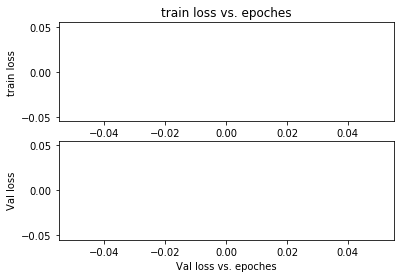

In [17]:
draw(train_loss_list, val_loss_list)

# 回归模型

### 回归模型定义

In [22]:
#超参数lambda
lamba = 0.2
batch_size2 = 32

In [23]:
# 定义LSTM的结构
class Change(nn.Module):
    def __init__(self):
        super(Change, self).__init__()
        #特征融合
        self.score_fc = torch.nn.Conv2d(64,3,kernel_size=1,stride=1)
        
    def forward(self, x):
        output = x
        #特征转换
        output_expand = output.expand([batch_size2, batch_size2, 64])
        output_expand = output_expand.unsqueeze(0).permute(0,3,1,2)
        score = self.score_fc(output_expand).squeeze(0)

        alignment_mat = score[0]
        l_mat = score[1]
        r_mat = score[2]
        
        I = torch.eye(batch_size2)
        allone = torch.ones(batch_size2, batch_size2)
        mask = allone-2*I

        l_reg = torch.mm(l_mat*I, torch.ones(batch_size2,1))
        r_reg = torch.mm(r_mat*I, torch.ones(batch_size2,1))
        offset_pred = torch.cat([l_reg, r_reg],1)
        
        loss_mat = torch.log(allone + torch.exp(mask * score[0]))
        
        para = I + 1.0 / batch_size2 * allone
        loss_mat = loss_mat * para
        loss_alignment = loss_mat.mean()
        
        return offset_pred, loss_alignment

In [24]:
train_loss_2_list=[]
val_loss_2_list=[]
resualt_text_path='C:/Users/wuxun/Desktop/resualt.txt'

### 训练函数

In [25]:
def train_2():
    change_model = Change()
    model = LSTM_CNN()
    model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/189epoch_20200713_64_dim_params.pkl'))
    change_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/the_first_model/the_first_model_epoch_158_batchsize1_params.pkl'))
    optimizer = optim.Adam(change_model.parameters(), lr = 0.0005)
    best_val_loss_2 = 1000000
    print("train begin......")
    for epoch in range(200):
        batch_train = batch_iter(x_batch_train, x_csv_train, y_csv_train, source_list_train, target_list_train, batch_size2)
        count = 0
        train_loss_sum = 0
        train_alignmentloss_sum = 0
        train_regloss_sum =0
        for x_batch, x_csv, y_csv, source_time, target_time in batch_train:
            if x_csv.shape[0]==batch_size2:
                count += 1
                x1 = Variable(torch.LongTensor(x_batch))
                x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                source_time = Variable(torch.FloatTensor(np.array(source_time)))
                target_time = Variable(torch.FloatTensor(np.array(target_time)))
                pred = model(x1, x2)
                pred2, loss_alignment = change_model(pred)
                train_alignmentloss_sum += loss_alignment
                loss_reg = torch.abs(pred2 - target_time).mean()
                train_regloss_sum += loss_reg
                Loss = loss_reg*lamba + loss_alignment
                train_loss_sum += Loss
                optimizer.zero_grad()
                Loss.backward()
                optimizer.step()
        print('Epoch: %d | Loss: %.3f | loss_align: %.3f | loss_reg: %.3f' % (epoch, train_loss_sum / (count), train_alignmentloss_sum / (count), train_regloss_sum / (count)))
        train_loss_2_list.append(train_loss_sum / count)

        if (epoch+1)%5==0:
            print("进行验证.......")
            batch_val = batch_iter(x_batch_val, x_csv_val, y_csv_val,source_list_val,target_list_val, batch_size2)
            count = 0
            val_loss_sum = 0
            val_alignmentloss_sum =0
            val_regloss_sum =0
            for x_batch, x_csv, y_csv, source_time, target_time in batch_val:
                if x_csv.shape[0]==batch_size2:
                    count += 1
                    x1 = Variable(torch.LongTensor(x_batch))
                    x2 = Variable(torch.FloatTensor(np.array(x_csv)))
                    source_time = Variable(torch.FloatTensor(np.array(source_time)))
                    target_time = Variable(torch.FloatTensor(np.array(target_time)))
                    pred = model(x1, x2)
                    pred2, loss_alignment = change_model(pred)
                    val_alignmentloss_sum += loss_alignment
                    loss_reg = torch.abs(pred2 - target_time).mean()
                    val_regloss_sum += loss_reg
                    #模型最终的loss
                    Loss = loss_reg * lamba + loss_alignment
                    val_loss_sum += Loss
                    optimizer.zero_grad()
                    Loss.backward()
                    optimizer.step()
            print('Epoch: %d | Loss: %.3f | loss_align: %.3f | loss_reg: %.3f' % (epoch, val_loss_sum / (count), val_alignmentloss_sum / (count), val_regloss_sum / (count)))
            val_loss_2_list.append(val_loss_sum / count) 
            torch.save(change_model.state_dict(), 'C:/Users/wuxun/Desktop/Data/save_model2/the_first_model/the_first_model_epoch_'+str(158 + epoch)+'_batchsize1_params.pkl')
            if (val_loss_sum / count ) < best_val_loss_2:
                torch.save(change_model.state_dict(), 'C:/Users/wuxun/Desktop/Data/save_model2/the_first_model/params.pkl')
                best_val_loss_2 = val_loss_sum / count
                print("model save!")

### 训练回归模型

In [22]:
train_2()

train begin......
Epoch: 0 | Loss: 23.496 | loss_align: 0.044 | loss_reg: 117.264
Epoch: 1 | Loss: 23.162 | loss_align: 0.043 | loss_reg: 115.592
Epoch: 2 | Loss: 23.138 | loss_align: 0.044 | loss_reg: 115.475
Epoch: 3 | Loss: 23.035 | loss_align: 0.044 | loss_reg: 114.954
Epoch: 4 | Loss: 22.928 | loss_align: 0.044 | loss_reg: 114.421
进行验证.......
Epoch: 4 | Loss: 22.683 | loss_align: 0.043 | loss_reg: 113.198
model save!
Epoch: 5 | Loss: 22.885 | loss_align: 0.043 | loss_reg: 114.206
Epoch: 6 | Loss: 22.804 | loss_align: 0.043 | loss_reg: 113.802
Epoch: 7 | Loss: 22.816 | loss_align: 0.044 | loss_reg: 113.862
Epoch: 8 | Loss: 22.898 | loss_align: 0.044 | loss_reg: 114.270
Epoch: 9 | Loss: 22.964 | loss_align: 0.043 | loss_reg: 114.600
进行验证.......
Epoch: 9 | Loss: 22.682 | loss_align: 0.043 | loss_reg: 113.193
model save!
Epoch: 10 | Loss: 22.860 | loss_align: 0.043 | loss_reg: 114.082
Epoch: 11 | Loss: 22.686 | loss_align: 0.044 | loss_reg: 113.212
Epoch: 12 | Loss: 22.881 | loss_alig

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: double, float, float16, int64, int32, and uint8.

### 绘制loss

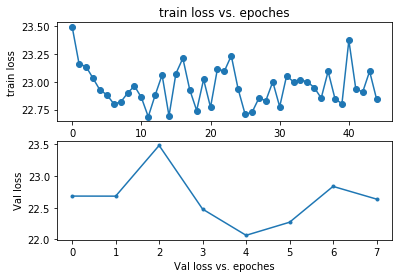

In [23]:
draw(train_loss_2_list, val_loss_2_list)

#### 计算R@1

In [27]:
middle_model = LSTM_CNN()
change_model = Change()
middle_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model/189epoch_20200713_64_dim_params.pkl'))
change_model.load_state_dict(torch.load('C:/Users/wuxun/Desktop/Data/save_model2/the_first_model/the_first_model_epoch_197_batchsize1_params.pkl'))

In [28]:
middle_model.eval()
change_model.eval()

Change(
  (score_fc): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [29]:
def read_vocab(vocab_dir):

    """读取词汇表"""

    with open(vocab_dir) as fp:
        words = [(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [30]:
#读取test集
# 读取test数据集
def get_test_dict_for_My_model(path, csv_path):
    words, word_to_id = read_vocab(vocab_dir)
    data_id = []
    csv=[]
    time_list=[]
    Max_len=-1
    count=0
    with open(path) as contents:
        for line in contents:
            count+=1
            List = line.split('#')
            video_name = List[0]
            time_length = float(List[1])
            foldtype = List[2]
            recipetype = List[3]
            target = List[4]
            
            #将句子转换为id表示：
            sentence = List[6].strip('\n').strip()
            sentence = re.split(r"[,| |.]",sentence)
            sentence_id = [word_to_id[x] for x in sentence if x in word_to_id]
            if len(sentence_id) > Max_len:
                Max_len = len(sentence_id)
            data_id.append(sentence_id)
            
            #寻找路径,先统一取0001
            dir_path = csv_path+'/'+foldtype+'/'+recipetype+'/'+video_name+'/0001/'
            name = os.listdir(dir_path)[0]
            dir_path = dir_path + name
            
            #读取csv文件
            my_file = Path(dir_path)
            if my_file.exists():
                frame_sum = pd.read_csv(dir_path, header=None)
            else:
                print("目录不存在！")
            
            #确定时间点，前帧后帧取pooling
            target = target.split('_')
            cur_start = float(target[0])
            cur_end = float(target[1])
            middle_time = (cur_start + cur_end)//2
            
            #中间帧
            target_frame_num = int(middle_time/time_length*500)
            target_middle_frame = frame_sum.loc[target_frame_num]
            
            csv.append(target_middle_frame)
            time_list.append([cur_start, cur_end])
            
    #将所有的句子pad为同一最大长度
    batch_data_id = np.array([line +[0]*(Max_len-len(line)) 
                                            for line in data_id])
    batch_seq = torch.LongTensor(batch_data_id)    
    print(len(batch_seq),len(csv),len(time_list))
    
    return batch_seq, csv, time_list

In [31]:
My_test_seq, My_test_csv, My_test_time_list = get_test_dict_for_My_model(val_path, csv_path)

523 523 523


In [34]:
IoU_thresh = [0.1, 0.3, 0.5, 0.7]

In [35]:
def calculate_IoU(i0, i1):
    # calculate temporal intersection over union
    union = (min(i0[0], i1[0]), max(i0[1], i1[1]))
    inter = (max(i0[0], i1[0]), min(i0[1], i1[1]))
    iou = 1.0*(inter[1]-inter[0])/(union[1]-union[0])
    return iou

In [36]:
def compute_IoU_recall_top_n_forreg(iou_thresh, time_mat, time_pre_mat):#top
    correct_num = 0
    for i in range(time_mat.shape[0]):
        gt_start = time_mat[i][0]
        gt_end = time_mat[i][1]
        pred_start = time_pre_mat[i][0]
        pred_end = time_pre_mat[i][1]
        iou = calculate_IoU((gt_start, gt_end),(pred_start, pred_end))
        if iou>=iou_thresh:
            correct_num+=1
    return correct_num

In [32]:
x = Variable(torch.LongTensor(My_test_seq))
y = Variable(torch.FloatTensor(np.array(My_test_csv)))
My_time_mat = Variable(torch.FloatTensor(np.array(My_test_time_list)))
batch_size = x.shape[0]
batch_size2 = x.shape[0]
My_output1 = middle_model(x, y)
My_pred_time_mat, _ = change_model(My_output1)

In [37]:
for iou_thresh in IoU_thresh:
    corrnum = compute_IoU_recall_top_n_forreg(iou_thresh, My_time_mat, My_pred_time_mat)
    corr_avg = corrnum*1.0 / My_time_mat.shape[0] 
    print("My_model: R@1 for iou_thresh: %.1f is : %.3f" % (iou_thresh, corr_avg))

My_model: R@1 for iou_thresh: 0.1 is : 0.140
My_model: R@1 for iou_thresh: 0.3 is : 0.069
My_model: R@1 for iou_thresh: 0.5 is : 0.028
My_model: R@1 for iou_thresh: 0.7 is : 0.005


In [41]:
begin_time_list = [x[0] for x in My_pred_time_mat.detach().numpy()] 

In [42]:
print(type(begin_time_list[0]))
print(len(begin_time_list))

<class 'numpy.float32'>
1548


In [43]:
Max_v=-1;
Min_v=2000
for i in range(len(begin_time_list)):
    if begin_time_list[i] > Max_v:
        Max_v=begin_time_list[i]
    if begin_time_list[i] < Min_v:
        Min_v=begin_time_list[i]

In [44]:
print(Max_v, Min_v)
num_block = ((Max_v - Min_v)/10)
print(num_block)

246.027 53.72785
19.229913330078126


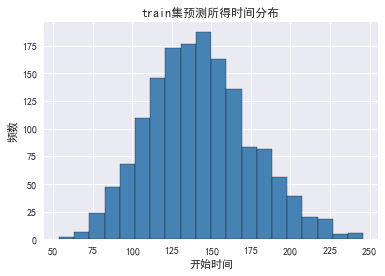

In [47]:
plt.hist(x = begin_time_list, # 指定绘图数据
         bins = 20, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('开始时间')
plt.ylabel('频数')
# 添加标题
plt.title('train集预测所得开始时间分布')
# 显示图形
plt.show()